In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
import csv
from astropy.stats import LombScargle
%matplotlib inline

In [2]:
def make_plot(title='', x_label='', y_label='', z_label='', x_lim=(0, 0), y_lim=(0,0), z_lim=(0,0), 
              grid=True, size=(10,5), dpi=100, font_size=20, label_size=14, three_d=False):
    '''
    Generates a plot object
    
    Parameters:
        title - (string) title of the plot
        x - (float) a list of values for omega/omega_0
        y - (float) a list of values for the amplitude
        xlim - (float) the limit for the x axis, this is a list containing 2 variables, 
                    the max and min value of x
        ylim - (float) the limit for the y axis, this is a list containing 2 variables, 
                    the max and min value of y
        size - (int) resizing the figure of the plot
        dpi - (int) increasing the quality of the image produced
    Returns:
        plot - (object) the plot
    '''
    fig = plt.figure(figsize=(size[0], size[1]), dpi=dpi)
    plot = fig.add_subplot(111) if not three_d else fig.add_subplot(111, projection='3d')
    
    plot.set_title(title, fontsize=font_size)
    if y_lim[0] != 0 or y_lim[1] !=0: plot.set_ylim(y_lim[0], y_lim[1])
    if x_lim[0] != 0 or x_lim[1] !=0: plot.set_xlim(x_lim[0], x_lim[1])
    if z_lim[0] != 0 or z_lim[1] !=0: plot.set_zlim(z_lim[0], z_lim[1])
    plot.set_xlabel(x_label, fontsize=font_size)
    plot.set_ylabel(y_label, fontsize=font_size)
    if three_d: plot.set_zlabel(z_label)
    if grid: plot.grid()
    plot.tick_params(labelsize=label_size);
    
    return plot

def make_plot_multipanel(title='', x_label='', y_label='', grid=True, size=(9, 6), 
                         dpi=115, font_size=20, label_size=14, npanels=(3, 2)):
    '''
    Generates a plot object
    
    Parameters:
        title - (string) title of the plot
        x - (float) a list of values for omega/omega_0
        y - (float) a list of values for the amplitude
        xlim - (float) the limit for the x axis, this is a list containing 2 variables, 
                    the max and min value of x
        ylim - (float) the limit for the y axis, this is a list containing 2 variables, 
                    the max and min value of y
        size - (int) resizing the figure of the plot
        dpi - (int) increasing the quality of the image produced
    Returns:
        plot - (object) the plot
    '''
    fig, axs = plt.subplots(*npanels, figsize=(size[0], size[1]), dpi=dpi)
    
    fig.suptitle(title, fontsize=font_size)
    for ax in axs:
        ax.set_xlabel(x_label, fontsize=font_size)
        ax.set_ylabel(y_label, fontsize=font_size)
        if grid: ax.grid()
        ax.tick_params(labelsize=label_size);
    
    return axs

def table_gen(title='', headers=[], data=[], aspect=1.0, rounding=8):
    '''
    Generates a matplotlib table
    
    Credit: P. Ciunkiewicz
    
    Parameters:
        title - (string) title of the table
        headers - (list or tuple) table column headers
        data - (array) array of data values for the table, first dimension must match headers
        aspect - (float) vertical scaling of the table, y:x aspect ratio
        rounding - (int) number of digits to round data values to before display
    Returns:
        none
    '''
    
    fig = plt.figure(figsize=(8,4))
    ax = plt.subplot()
    
    content = np.round(data, rounding)
    table = ax.table(cellText=content, colLabels=headers, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, aspect)
    ax.set_title(title)
    ax.axis('off')
    
    fig.tight_layout()
    plt.show()

## 1.1

https://www.youtube.com/watch?v=jE07a66rkRQ

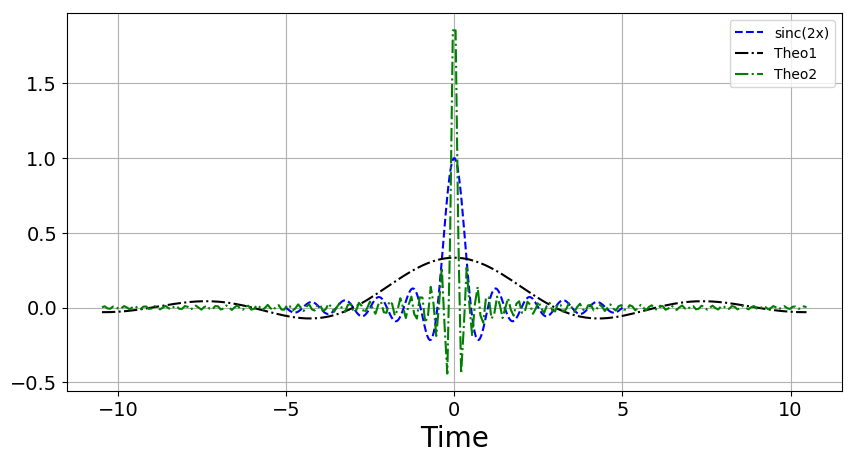

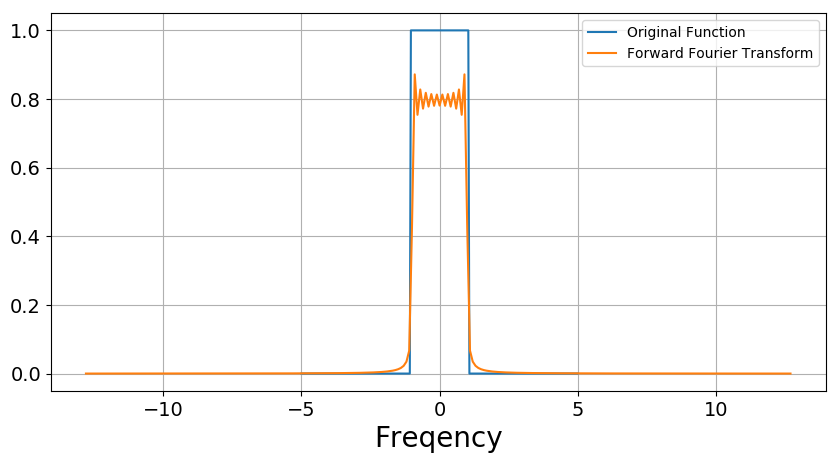

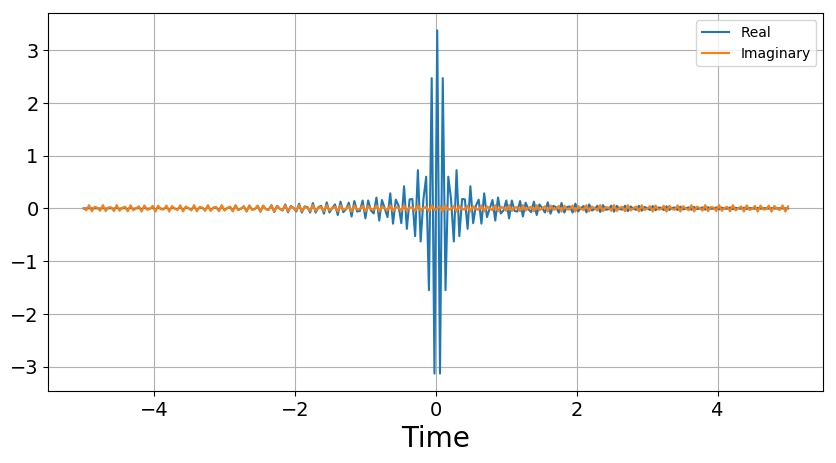

In [137]:
def X(omega, box_bounds=(np.pi/3)):
    y = np.zeros(omega.shape) 
    y[np.abs(omega) <= box_bounds] = 1
    return y

def analytic_x(t, N):
    return np.exp(1j*np.pi*t*(1-1/N))*np.sin(np.pi*t)/np.sin(np.pi*t/N)/N

def fn1(n):
    return np.sin(n*np.pi/3)/n/np.pi

def fn2(n):
    return np.sinc(2*n*(np.pi**2)/3)*2*np.pi/3

N = 2**8
x = np.linspace(-5, 5, N)
n = np.linspace(-10*np.pi/3, 10*np.pi/3, N)
f = X(x)
time_domain = np.fft.ifft(f, norm='ortho')
fourier = np.fft.fft(np.sinc(2*x), norm='ortho')

plot = make_plot(x_label='Time')
#plot.plot(x, analytic_x(x, N).real, 'r.-', label='Analytic')
plot.plot(x, np.sinc(2*x), 'b--', label="sinc(2x)")
plot.plot(n, fn1(n), 'k-.', label="Theo1")
plot.plot(n, fn2(n), 'g-.', label="Theo2")
plot.legend()

plot = make_plot(x_label='Freqency')
plot.plot(x, f, label="Original Function")
plot.plot(np.fft.fftshift(np.fft.fftfreq(len(fourier), d=10/N)), np.fft.fftshift(np.abs(fourier)), label="Forward Fourier Transform")
plot.legend()

plot = make_plot(x_label='Time')
plot.plot(x, np.fft.fftshift(time_domain.real), label='Real')
plot.plot(x, np.fft.fftshift(time_domain.imag), label='Imaginary')
plot.legend();

The theoretical numpy FFT doesn't give the expected function due to what I believe is normalization errors. It is highly dependent on the number of points input, which should not be the case.

In [4]:
def twoD_map(fn, matrix, args=()):
    '''
    Fills a square, 2D matrix with a function
    '''
    width, height = matrix.shape
    
    for w in range(width):
        for h in range(height):
            matrix[w, h] = fn(w, h, *args)
    
    return matrix
            
def DFT_matrix(n, m, N):
    return np.exp(-1j*2*np.pi*n*m/N)

def IDFT_matrix(n, m, N):
    return np.exp(1j*2*np.pi*n*m/N)/N

N = 3
f = twoD_map(DFT_matrix, np.zeros((N, N), dtype=np.complex), args=(N,))
i = twoD_map(IDFT_matrix, np.zeros((N, N), dtype=np.complex), args=(N,))

print("Forward:\n", f), print("Inverse:\n", i), print("Dot Product:\n", np.round(np.dot(i, f), 8));

Forward:
 [[ 1. +0.j         1. +0.j         1. +0.j       ]
 [ 1. +0.j        -0.5-0.8660254j -0.5+0.8660254j]
 [ 1. +0.j        -0.5+0.8660254j -0.5-0.8660254j]]
Inverse:
 [[ 0.33333333+0.j          0.33333333+0.j          0.33333333+0.j        ]
 [ 0.33333333+0.j         -0.16666667+0.28867513j -0.16666667-0.28867513j]
 [ 0.33333333+0.j         -0.16666667-0.28867513j -0.16666667+0.28867513j]]
Dot Product:
 [[ 1.+0.j -0.-0.j  0.-0.j]
 [-0.+0.j  1.+0.j -0.-0.j]
 [ 0.+0.j -0.+0.j  1.+0.j]]


In [5]:
N = 4
f_N4 = twoD_map(DFT_matrix, np.zeros((N, N), dtype=np.complex), args=(N,))
x = np.array([1,0,-1,0]).T

print(f_N4), print(np.dot(f_N4, x));

[[ 1.0000000e+00+0.0000000e+00j  1.0000000e+00+0.0000000e+00j
   1.0000000e+00+0.0000000e+00j  1.0000000e+00+0.0000000e+00j]
 [ 1.0000000e+00+0.0000000e+00j  6.1232340e-17-1.0000000e+00j
  -1.0000000e+00-1.2246468e-16j -1.8369702e-16+1.0000000e+00j]
 [ 1.0000000e+00+0.0000000e+00j -1.0000000e+00-1.2246468e-16j
   1.0000000e+00+2.4492936e-16j -1.0000000e+00-3.6739404e-16j]
 [ 1.0000000e+00+0.0000000e+00j -1.8369702e-16+1.0000000e+00j
  -1.0000000e+00-3.6739404e-16j  5.5109106e-16-1.0000000e+00j]]
[0.+0.0000000e+00j 2.+1.2246468e-16j 0.-2.4492936e-16j 2.+3.6739404e-16j]


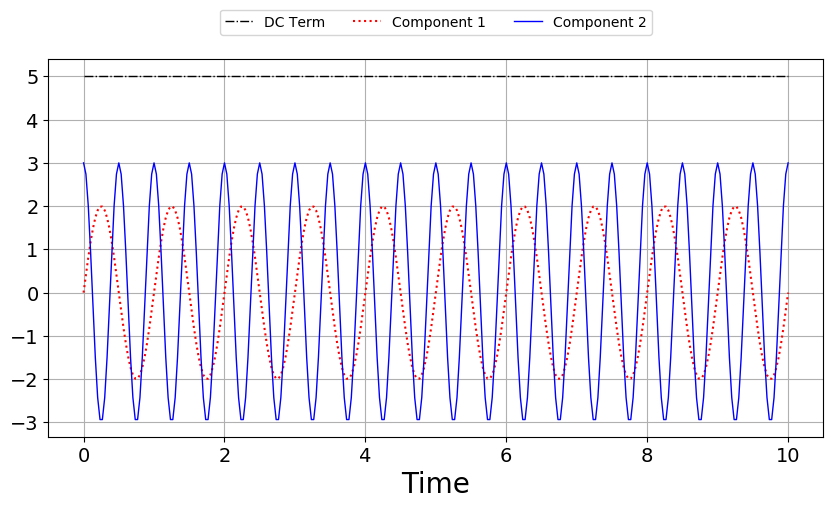

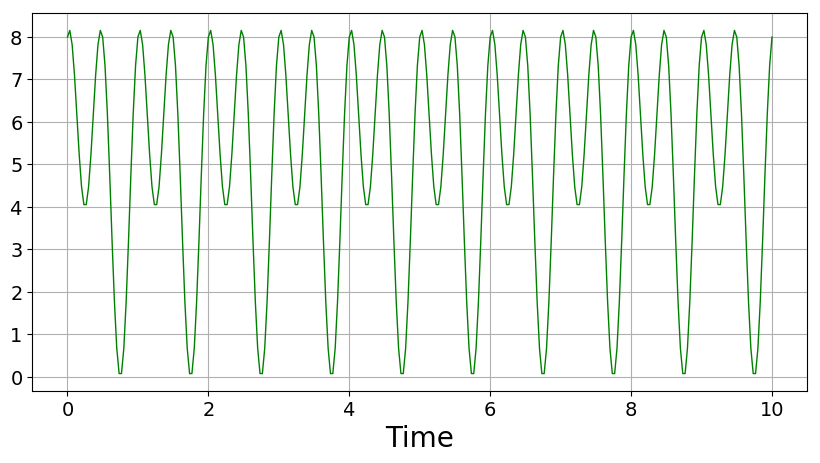

In [6]:
def signal_11(x):
    return 5 + 2*np.cos(2*np.pi*x-np.pi/2) + 3*np.cos(4*np.pi*x)

x = np.linspace(0, 10, 301)
line_width  = 1

plot = make_plot(x_label='Time')
plot.plot(x, np.ones(len(x))*5, 'k-.', label='DC Term', linewidth=line_width)
plot.plot(x, 2*np.cos(2*np.pi*x-np.pi/2), 'r:', label='Component 1', linewidth=1.5*line_width)
plot.plot(x, 3*np.cos(4*np.pi*x), 'b-', label='Component 2', linewidth=line_width)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3);

plot = make_plot(x_label='Time')
plot.plot(x, signal_11(x), 'g-', label='Total Signal', linewidth=line_width);

[8.+0.j 4.+0.j 8.+0.j 0.+0.j]
[[ 1.0000000e+00+0.0000000e+00j  1.0000000e+00+0.0000000e+00j
   1.0000000e+00+0.0000000e+00j  1.0000000e+00+0.0000000e+00j]
 [ 1.0000000e+00+0.0000000e+00j  6.1232340e-17-1.0000000e+00j
  -1.0000000e+00-1.2246468e-16j -1.8369702e-16+1.0000000e+00j]
 [ 1.0000000e+00+0.0000000e+00j -1.0000000e+00-1.2246468e-16j
   1.0000000e+00+2.4492936e-16j -1.0000000e+00-3.6739404e-16j]
 [ 1.0000000e+00+0.0000000e+00j -1.8369702e-16+1.0000000e+00j
  -1.0000000e+00-3.6739404e-16j  5.5109106e-16-1.0000000e+00j]]
[ 1.5+0.j  -0.5+0.5j -0.5-0.j  -0.5-0.5j]
[1.5        0.70710678 0.5        0.70710678]


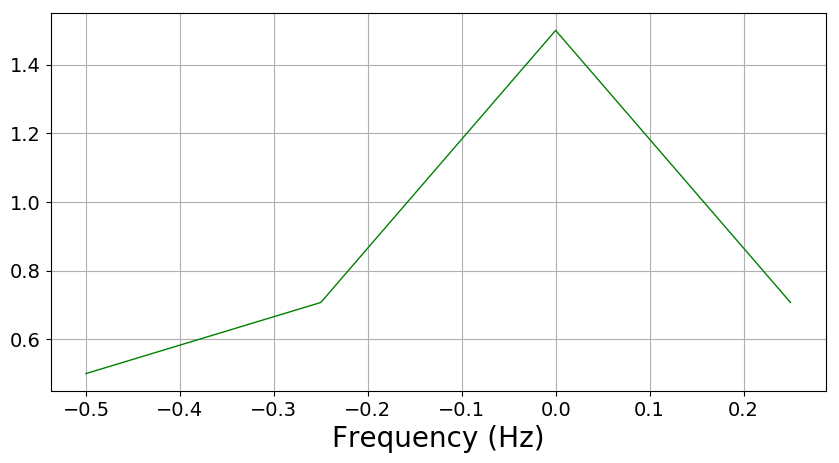

In [7]:
x = np.arange(0, 1, 1/4, dtype=np.complex).T
line_width  = 1
fourier_transform = np.dot(f_N4, x)

print(signal_11(x)), print(f_N4), print(np.round(fourier_transform, 4)), print(np.abs(np.round(fourier_transform, 4)));

plot = make_plot(x_label='Frequency (Hz)')
plot.plot(np.fft.fftshift(np.fft.fftfreq(len(x))), np.fft.fftshift(np.abs(fourier_transform)), 'g-', label='Total Signal', linewidth=line_width);

# General Applications

In [8]:
folder = 'DataFiles/'

## 2.2 Heart Beats

Padding is not necessary, since the number of points in the sequence is already a power of 2 ($2^{12}$)

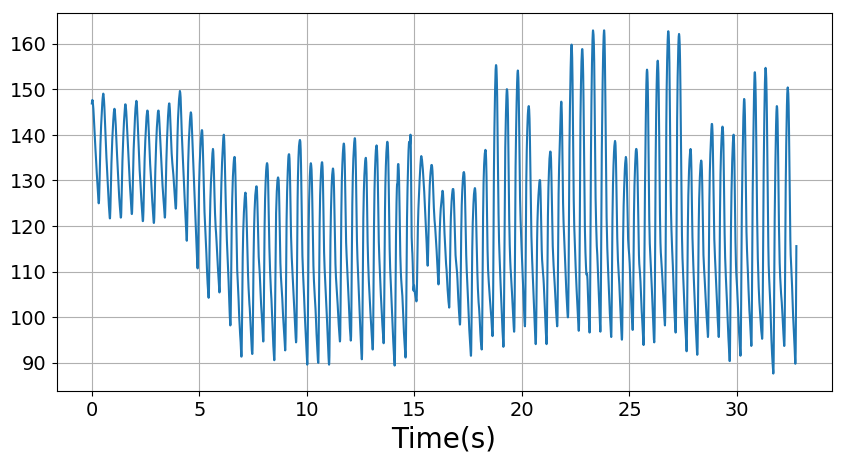

In [9]:
data = np.genfromtxt( folder + 'phys581-beats.txt', usecols=(0), names=['samples'] )
y = data['samples']
x = np.arange(0, 4096/125, 1/125)

make_plot(x_label='Time(s)').plot(x, y);

First max: (13513.388032099385-1166.8183751307965j) | Index: 66 | Period: 0.4964848484848485 | Frequency: 2.01416015625
Second max: (4602.658973198209-3256.7534319148954j) | Index: 131 | Period: 0.25013740458015266 | Frequency: 3.997802734375


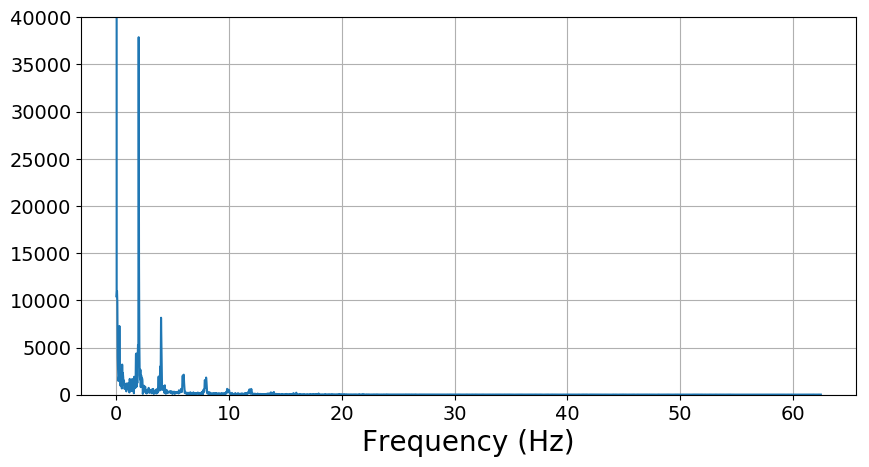

In [138]:
dft_beats = np.fft.rfft(y)
frequencies = np.fft.rfftfreq(len(y), d=1/125)

print("First max:", dft_beats[5:80].max(), "| Index:", dft_beats[5:80].argmax()+5, "| Period:", 1/frequencies[66], "| Frequency:", frequencies[66])
print("Second max:", dft_beats[80:].max(), "| Index:", dft_beats[80:].argmax()+80, "| Period:", 1/frequencies[131], "| Frequency:", frequencies[131])

plot = make_plot(x_label='Frequency (Hz)', y_lim=(-1, 40000))
plot.plot(frequencies, np.abs(dft_beats));

These periods make sense if the person was going for a run or something of the like, where their heartbeat would be approximately 120 beats/minute, as the period is telling us.

## 2.4 Application to Financial Series

In [11]:
def auto_correlation(x):
    '''
    Finds the auto correlation of a digital signal
    '''
    avg = np.average(x)
    sigma2 = np.sum((x - avg)**2)
    return [np.sum((x-avg)*(np.roll(x, k)-avg))/sigma2 for k in range(len(x))]

def import_text(filename, separator):
    '''
    Source: https://stackoverflow.com/questions/482405/parsing-a-file-with-column-data-in-python
    '''
    for line in csv.reader(open(filename), delimiter=separator, 
                           skipinitialspace=True):
        if line:
            yield line
            
def cont_compounded_returns(series):
    return np.log(series[1:]/np.roll(series, 1)[1:])*100

In [12]:
months = {'Jan':0, 'Feb':31, 'Mar':59, 'Apr':90, 'May':120, 'Jun':151, 'Jul':181, 'Aug':212, 'Sep':243, 'Oct':273, 'Nov':304, 'Dec':334}

data = np.array([date for date in import_text(folder + 'phys581-stocks.txt', '	')])
names = data[:1][0, 1:]
dates = data[1:, 0]

data_arr = np.array(data.T[1:, 1:], dtype=np.float64)

times = [months[date[:3]]/365 + int(date[4:]) + 2000 for date in dates]

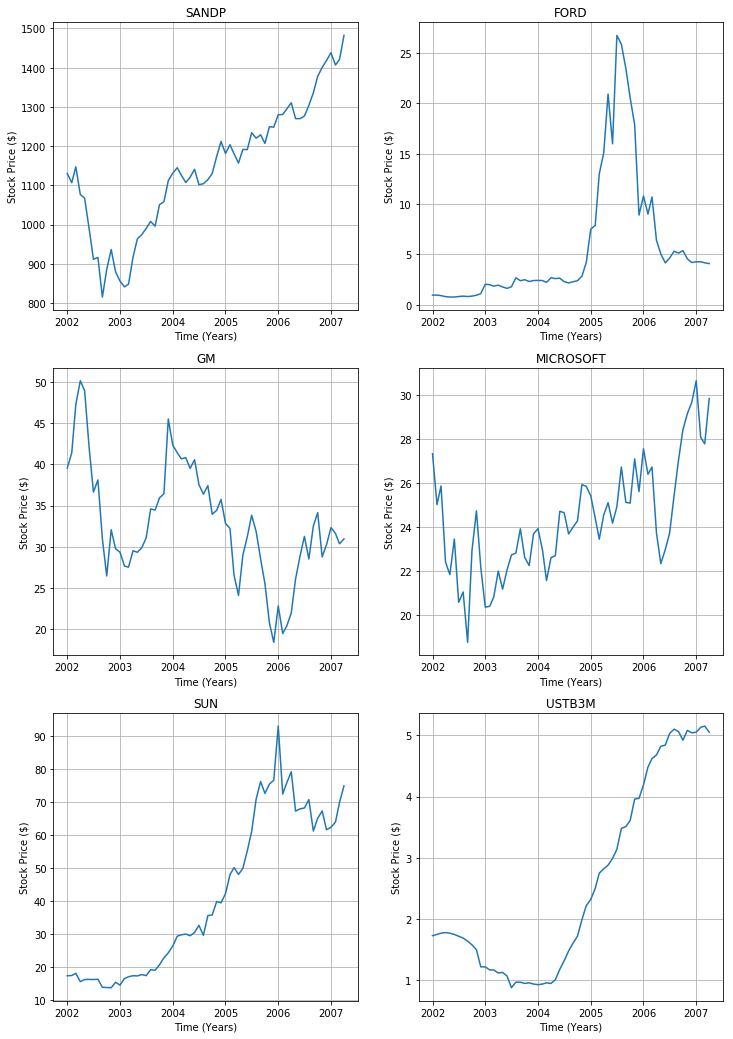

In [13]:
fig1, ax1 = plt.subplots(3, 2, figsize=(12,18))
ax1 = ax1.reshape(6)

for name, series, ax in zip(names, data_arr, ax1):
    ax.plot(times, series)
    ax.set_title(str(name))
    ax.set_ylabel('Stock Price ($)')
    ax.set_xlabel('Time (Years)')
    ax.grid()

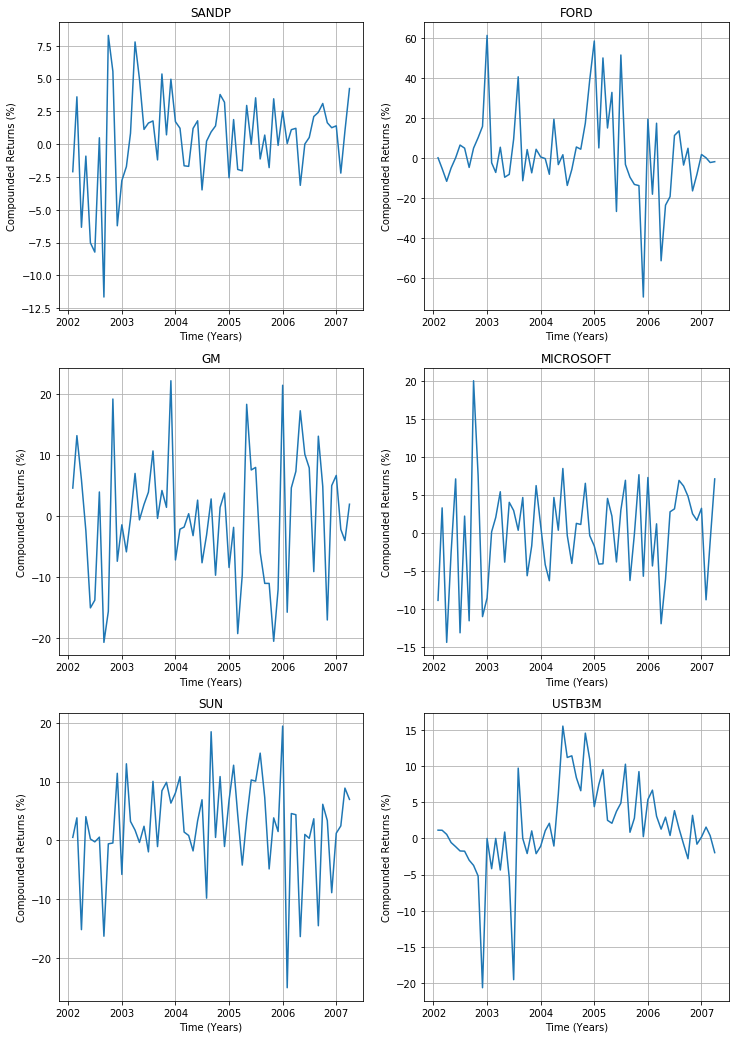

In [14]:
comp_returns = []
fig1, ax1 = plt.subplots(3, 2, figsize=(12,18))
ax1 = ax1.reshape(6)

for name, series, ax in zip(names, data_arr, ax1):
    returns = cont_compounded_returns(series)
    comp_returns.append(returns)
    
    ax.plot(times[1:], returns)
    ax.set_title(str(name))
    ax.set_ylabel('Compounded Returns (%)')
    ax.set_xlabel('Time (Years)')
    ax.grid()

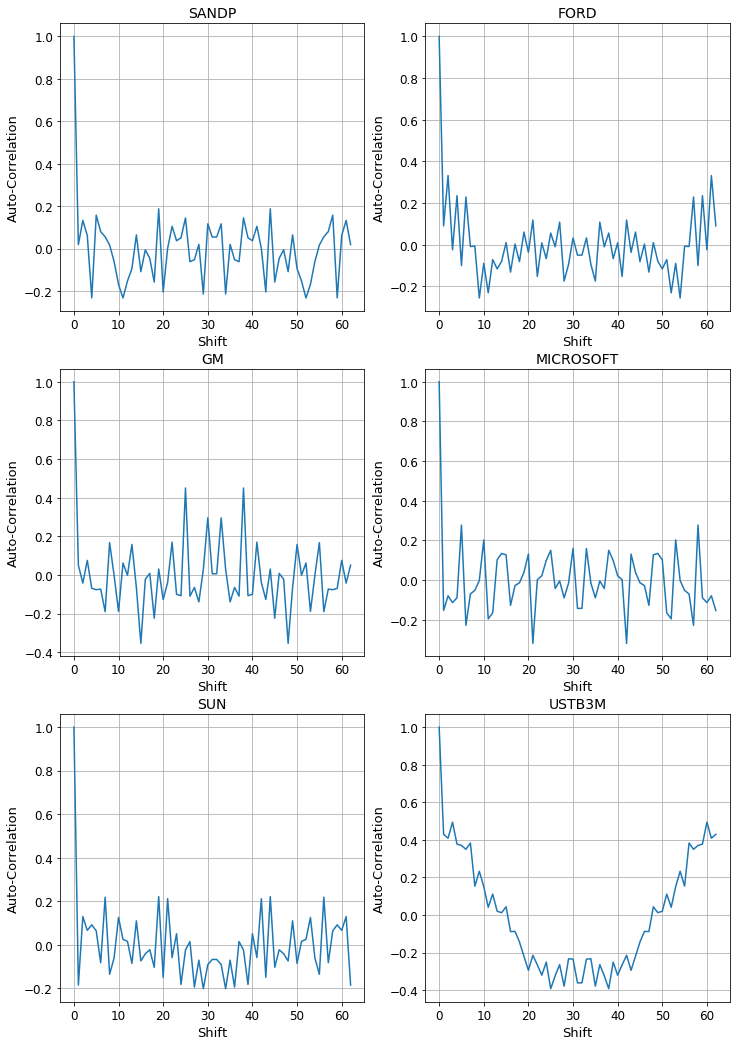

In [27]:
fig1, ax1 = plt.subplots(3, 2, figsize=(12,18))
axs = ax1.reshape(6)

autos = []

for name, series, ax in zip(names, comp_returns, axs):
    auto = auto_correlation(series)
    autos.append(auto)
    
    ax.plot(auto)
    ax.set_title(str(name), fontsize=14)
    ax.set_ylabel('Auto-Correlation', fontsize=13)
    ax.set_xlabel('Shift', fontsize=13)
    ax.grid()
    ax.tick_params(labelsize=12)

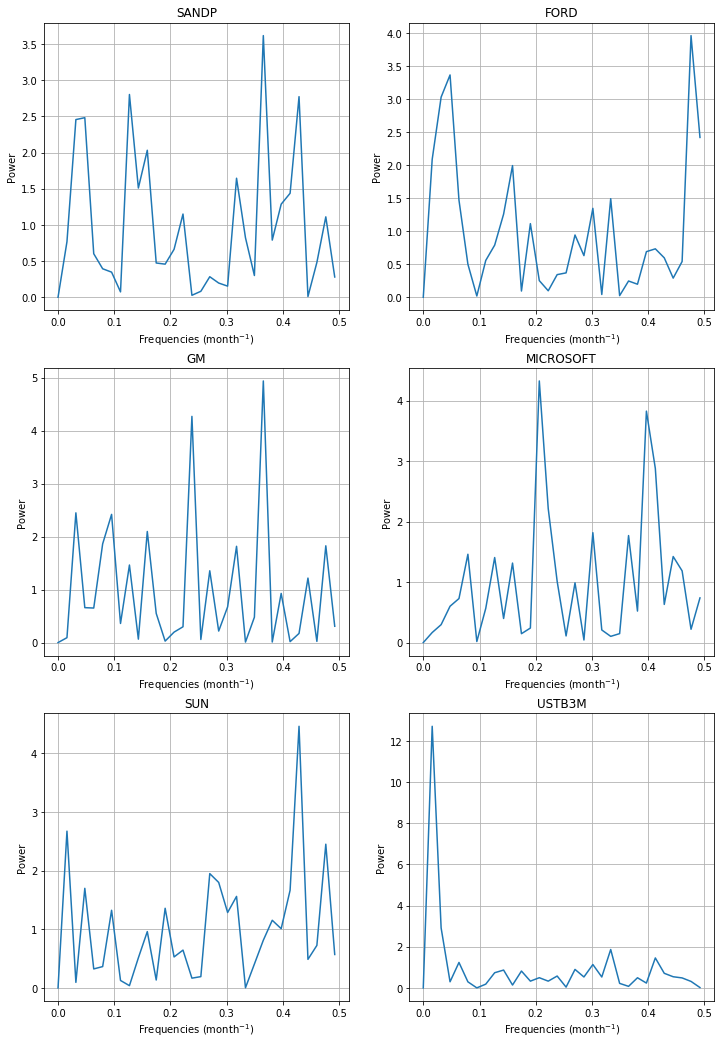

In [96]:
fig1, ax1 = plt.subplots(3, 2, figsize=(12,18))
axs = ax1.reshape(6)

for name, auto, ax in zip(names, autos, axs):
    ps = np.abs(np.fft.rfft(auto))
    
    ax.plot(np.fft.rfftfreq(len(auto), d=1), ps)
    ax.set_title(str(name))
    ax.set_ylabel('Power')
    ax.set_xlabel('Frequencies (month$^{-1}$)')
    ax.grid()

First max: 6896855831.763074 | Index: 13 | Period: 78.76923076923077 | Frequency: 0.0126953125


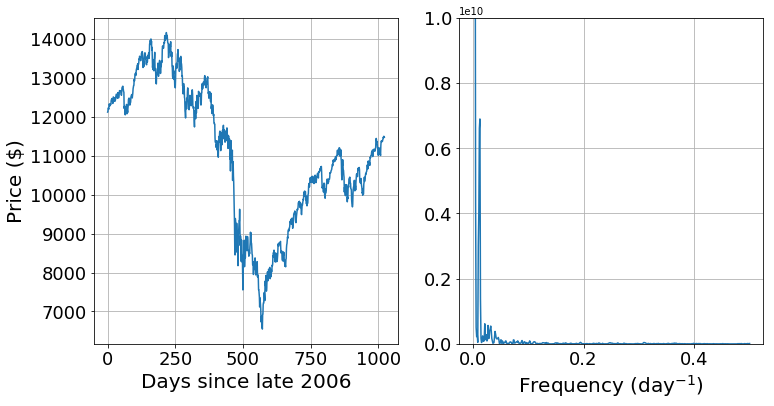

In [190]:
def hann_window(n):
    '''
    Hann window formula
    
    Parameters:
        n - (array-like) point(s) at which to calculate the hann window. 0 < n < 1
    Returns:
        (array-like) hann window at point(s) n
    '''
    return 0.5*(1-np.cos(2*np.pi*n))

dow_data = np.genfromtxt( folder + 'phys581-dow.txt', usecols=(0))
windowed_data = dow_data*hann_window(np.linspace(0, 1, len(dow_data)))
dow_power = (np.abs(np.fft.rfft(windowed_data))**2).real
dow_frequencies = np.fft.rfftfreq(len(dow_data), d=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(dow_data)
axs[0].set_ylabel('Price ($)', fontsize=20)
axs[0].set_xlabel('Days since late 2006', fontsize=20)
axs[0].grid()
axs[0].tick_params(labelsize=18);

axs[1].plot(dow_frequencies, dow_power)
axs[1].set_xlabel('Frequency (day$^{-1}$)', fontsize=20)
axs[1].grid()
axs[1].set_ylim(0, 10**10)
axs[1].tick_params(labelsize=18);

print("First max:", dow_power[5:].max(), "| Index:", dow_power[5:].argmax()+5, "| Period:", 1/dow_frequencies[13], "| Frequency:", dow_frequencies[13])

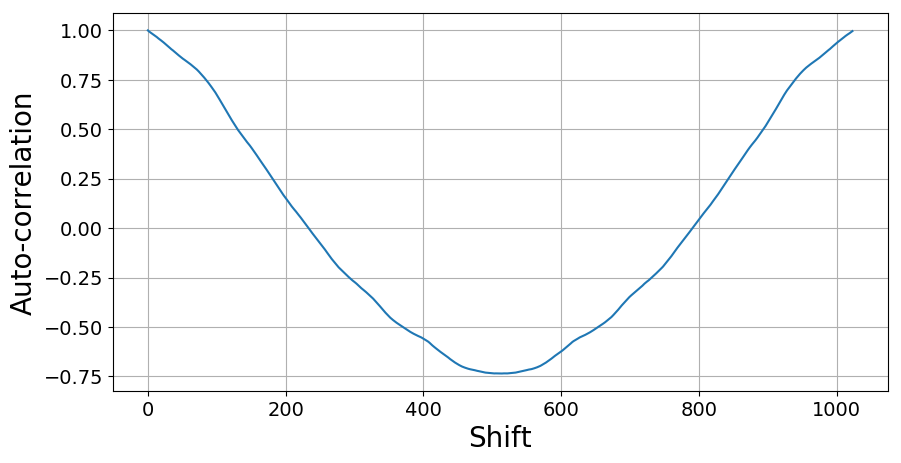

In [140]:
make_plot(y_label='Auto-correlation', x_label='Shift').plot(auto_correlation(dow_data));

## 2.5 Global Warming

Text(0,0.5,'$CO_2$ concentration')

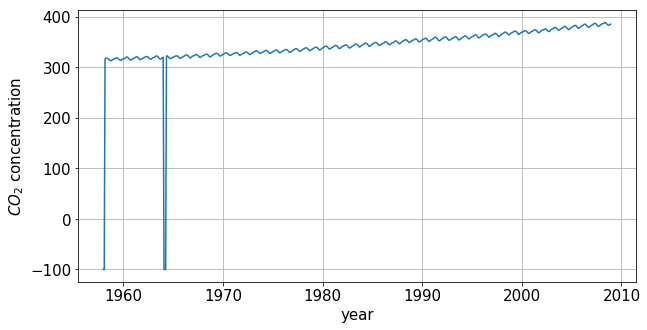

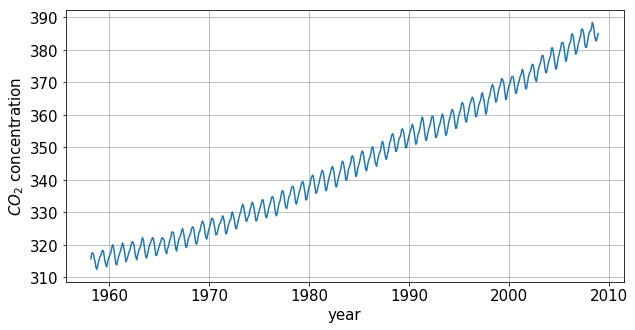

In [98]:
url = folder + 'phys581-co2.txt'
data = np.genfromtxt( url, usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12) )

year = np.arange(1958, 2009, 1/12)

data = data[:,1:]
data = data.reshape(data.shape[0]*data.shape[1])

plt.figure(figsize=(10,5))
plt.plot(year, data)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('$CO_2$ concentration', fontsize=15)

gooddates = np.where(data>0)
data = data[gooddates]
year = year[gooddates]

plt.figure(figsize=(10,5))
plt.plot(year, data)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('$CO_2$ concentration', fontsize=15)

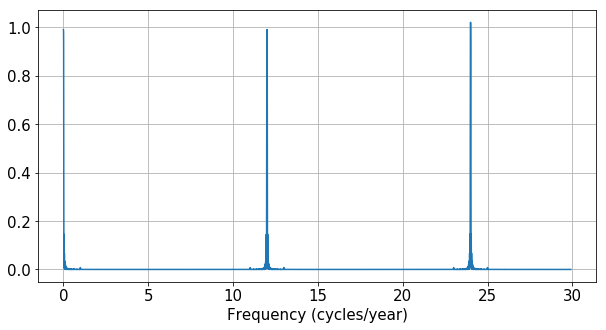

In [72]:
frequency, power = LombScargle(year, data).autopower()

plt.figure(figsize=(10,5))
plt.plot(frequency, power)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/year)', fontsize=15);

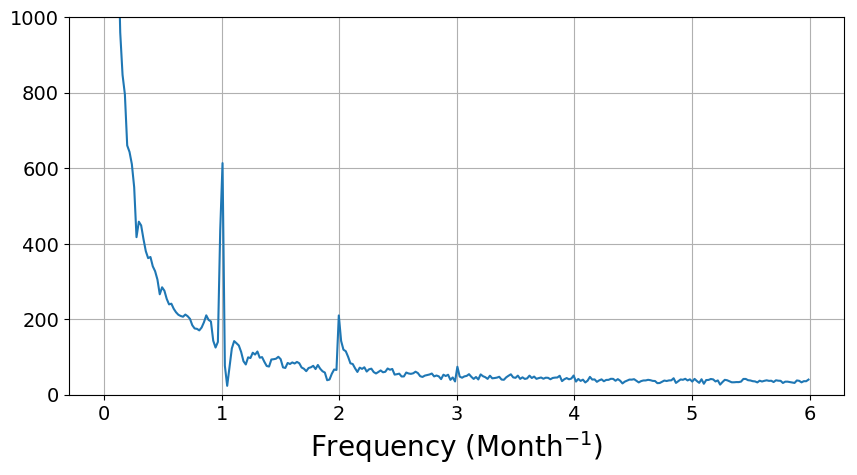

In [73]:
Tdata = np.fft.rfft(data)
freq = np.fft.rfftfreq(len(data), d=1/12)

make_plot(x_label='Frequency (Month$^{-1}$)', y_lim=(0,1000)).plot(freq, np.abs(Tdata));

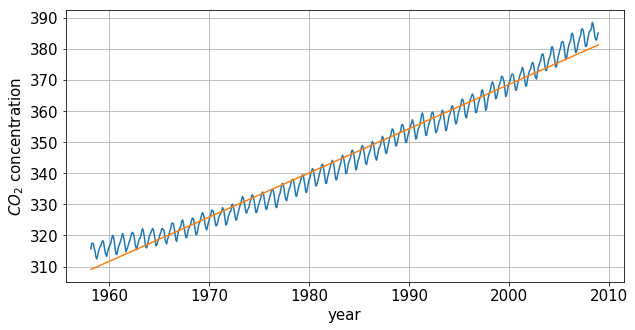

In [74]:
coefs = np.polyfit(year, data, 1)
fitfunc = np.polyval(coefs, year)

plt.figure(figsize=(10,5))
plt.plot(year, data)
plt.plot(year, fitfunc)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('$CO_2$ concentration', fontsize=15);

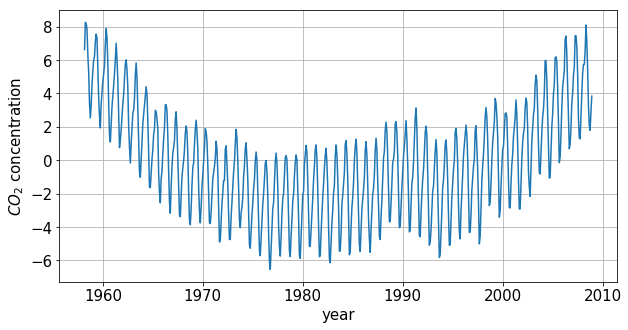

In [88]:
data_mtrend = data - fitfunc

plt.figure(figsize=(10,5))
plt.plot(year, data_mtrend)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('$CO_2$ concentration', fontsize=15);

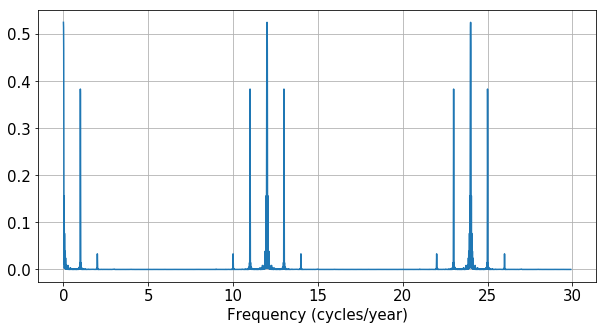

In [89]:
frequency, power = LombScargle(year, data_mtrend).autopower(method='chi2')

plt.figure(figsize=(10,5))
plt.plot(frequency, power)
plt.grid('on')
plt.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/year)', fontsize=15);